# 量子鍵配送

## Contents

1. はじめに
2. プロトコルの概要
3. Qiskitの例: 盗聴なし
4. Qiskitの例: 盗聴あり
5. リスク分析

## 1. はじめに

アリスとボブが、安全でない通信路（例えばインターネット）上で秘密のメッセージ（例えばボブのオンラインバンクの詳細）をやりとりしたい場合、メッセージを暗号化することが必要です。暗号は広い分野で、そのほとんどはこのテキストの範囲外なので、アリスとボブが他の誰にも知られていない秘密鍵を持っていればそれが役に立ち、共通鍵暗号で通信できる、ということを信頼するほかはありません。

アリスとボブがイブの古典的通信路を使って鍵を共有したい場合、イブが自分用にこの鍵のコピーを作ったかどうかを知ることは不可能です。つまり、盗聴されていないということについて、イブを全面的に信頼するしかありません。ところが、もしイブが量子的通信路を提供しているのであれば、アリスとボブはもはやイブを信頼する必要はありません。つまり、ボブのメッセージがアリスに届く前にイブがそれを読もうとすれば、彼らにはそのことがわかるのです。

量子的通信路が物理的にどのように実装されるのか、そのイメージをお伝えするとわかりやすい方もいるかもしれません。古典的通信路は例えば電話線に例えることができます。電話線を通じて、電気信号であらわされたメッセージ（ないしビット列）を送ります。提案されている量子的通信路の例としては、例えばある種の光ファイバーケーブルを挙げることができるでしょう。これを通じて1個ずつの光子（光の粒子）を送ることができます。光子には _偏光_ と呼ばれる特性があり、この偏光は2つの状態のうちのいずれかを取ることができます。これを使って、量子ビットを表現することができます。


## 2. プロトコルの概要  

このプロトコルは、量子ビットを測定するとその量子ビットの状態が変化しうる、という事実を利用しています。アリスがボブに量子ビットを送り、ボブが測定する前に盗聴者（イブ）が測定を試みると、イブの測定によって量子ビットの状態が変化し、アリスが送信した量子ビットの状態がボブに届かない可能性があります。

In [1]:
from qiskit import QuantumCircuit, execute, Aer
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from numpy.random import randint
import numpy as np
print("Imports Successful")

Imports Successful


アリスが状態 $|+\rangle$ (X基底で `0`) の量子ビットを準備し、ボブがそれをX基底で測定すれば、ボブは必ず `0` を得ます：

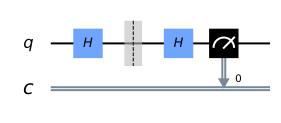

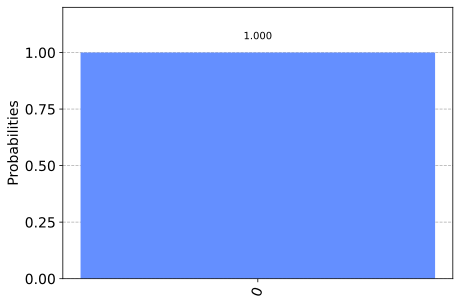

In [2]:
qc = QuantumCircuit(1,1)
# Alice prepares qubit in state |+>
qc.h(0)
qc.barrier()
# Alice now sends the qubit to Bob
# who measures it in the X-basis
qc.h(0)
qc.measure(0,0)

# Draw and simulate circuit
display(qc.draw())
svs = Aer.get_backend('qasm_simulator')
job = execute(qc, svs)
plot_histogram(job.result().get_counts())

しかしこの量子ビットがボブに届く前にイブがZ基底での測定を試みると、量子ビットの状態を $|+\rangle$ から $|0\rangle$ または $|1\rangle$ のどちらかに変えることになり、ボブが測定して0を得ることはもはや確実ではなくなります：

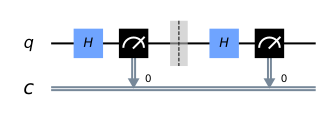

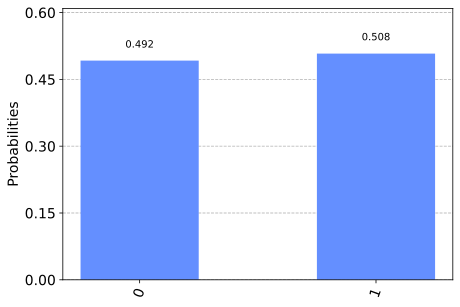

In [3]:
qc = QuantumCircuit(1,1)
# Alice prepares qubit in state |+>
qc.h(0)
# Alice now sends the qubit to Bob
# but Eve intercepts and tries to read it
qc.measure(0, 0)
qc.barrier()
# Eve then passes this on to Bob
# who measures it in the X-basis
qc.h(0)
qc.measure(0,0)

# Draw and simulate circuit
display(qc.draw())
svs = Aer.get_backend('qasm_simulator')
job = execute(qc, svs)
plot_histogram(job.result().get_counts())

このように、ボブは50%の確率で `1` を測定する可能性があることがわかります。そしてもし `1` を測定すれば、彼とアリスは自分たちが使っている通信路に何か問題があるということがわかります。

量子鍵配送プロトコルは、このプロセスをじゅうぶんな回数繰り返して、盗聴者がこの迎撃から逃れる可能性がほとんどなくなるようにする方法です。おおまかには次のようになります：

**- ステップ1**

アリスはランダムなビット列を選びます。たとえば：

`1000101011010100`

そして、各ビットに対応するランダムな基底を選びます：

`ZZXZXXXZXZXXXXXX`

アリスは、この2種類の情報を自分だけの秘密として持っておきます。

**- ステップ2**

次にアリスは、各ビットを自分が選んだ基底を使って量子ビット列上にエンコードします。そうすると、各量子ビットは、ランダムに選ばれた $|0\rangle$, $|1\rangle$, $|+\rangle$, $|-\rangle$ のいずれかの状態になります。この場合、量子ビット列は次のようになるでしょう：

$$ |1\rangle|0\rangle|+\rangle|0\rangle|-\rangle|+\rangle|-\rangle|0\rangle|-\rangle|1\rangle|+\rangle|-\rangle|+\rangle|-\rangle|+\rangle|+\rangle
$$

これが、彼女がボブに送るメッセージになります。

**- ステップ3**

次にボブは、それぞれの量子ビットをランダムに測定します。たとえば次のような基底を使うかもしれません：

`XZZZXZXZXZXZZZXZ`

そしてボブはその測定結果を秘密にしておきます。

**- ステップ4**

そうしてからボブとアリスは、各量子ビットに対して自分たちが使った基底を公開しあいます。アリスがある量子ビットを用意したときに使った基底と同じ基底を使って、ボブがその量子ビットを測定していた場合には、彼らが共有する秘密鍵の一部としてそのビットを使用することにします。そうでなかった場合には、そのビットについての情報は捨てます。

**- ステップ5**

最後に、ボブとアリスは彼らの鍵のなかからランダムなサンプルを共有します。そのサンプルが一致していれば、（誤りの余地が少しばかりありますが）伝送が成功したと信じることができます。


## 3. Qiskitの例: 盗聴なし

まず最初に、誰も盗聴していない場合にこのプロトコルがうまくいくことを見ましょう。それから、アリスとボブが盗聴者をどうやって検出することができるのかを示します。いつものように、最初にまず必要なものをすべてインポートしましょう：

擬似ランダム鍵を生成するには、numpyの `randint` 関数を使います。このページに示したのと同じ結果が再現していただけるよう、種には 0 を設定しておきます：

In [4]:
np.random.seed(seed=0)

アリスの最初のメッセージの長さを `n` と呼ぶことにします。この例では、アリスは100量子ビットの長さのメッセージを送ります：

In [5]:
n = 100

### 3.1 ステップ1:

アリスはランダムなビット列を生成します：

In [6]:
np.random.seed(seed=0)
n = 100
## Step 1
# Alice generates bits
alice_bits = randint(2, size=n)
print(alice_bits)

[0 1 1 0 1 1 1 1 1 1 1 0 0 1 0 0 0 0 0 1 0 1 1 0 0 1 1 1 1 0 1 0 1 0 1 1 0
 1 1 0 0 1 0 1 1 1 1 1 0 1 0 1 1 1 1 0 1 0 0 1 1 0 1 0 1 0 0 0 0 0 1 1 0 0
 0 1 1 0 1 0 0 1 0 1 1 1 1 1 1 0 1 1 0 0 1 0 0 1 1 0]


この時点では、ビット列 '`alice_bits`' はアリスしか知りません。アリスだけが知っている情報は何か、ボブだけが知っている情報は何か、イブの通信路を流れたのは何か、をこのような表で追跡することにします：

| Alice's Knowledge |Over Eve's Channel| Bob's Knowledge |
|:-----------------:|:----------------:|:---------------:|
|     alice_bits    |                  |       &nbsp;    |

### 3.2 ステップ2:

アリスは各ビットを、ランダムに選んだ $X$ または $Z$基底を使って量子ビット上にエンコードします。選んだ基底は `alice_bases` に保持します。ここでは、 `0` は「$Z$基底を使った」、`1` は「$X$基底を使った」ことを意味します。

In [7]:
np.random.seed(seed=0)
n = 100
## Step 1
#Alice generates bits
alice_bits = randint(2, size=n)

## Step 2
# Create an array to tell us which qubits
# are encoded in which bases
alice_bases = randint(2, size=n)
print(alice_bases)

[1 0 0 1 0 0 0 1 1 0 1 0 0 0 0 0 1 0 1 0 1 1 1 1 1 0 1 1 1 1 0 1 1 0 0 1 0
 0 0 0 1 1 0 0 1 0 1 1 1 1 0 0 0 1 0 1 1 1 0 1 0 0 1 0 1 1 0 0 1 0 1 0 1 0
 1 0 1 0 0 0 1 0 1 0 1 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0]


アリスはこれも秘密にしておきます：

| Alice's Knowledge |Over Eve's Channel| Bob's Knowledge |
|:-----------------:|:----------------:|:---------------:|
|     alice_bits    |                  |                 |
|    alice_bases    |                  |     &nbsp;      |

下記の `encode_message` 関数は `QuantumCircuit` のリストを生成します。リストの各要素が、アリスのメッセージに含まれる個々の量子ビットを表しています：

In [8]:
def encode_message(bits, bases):
    message = []
    for i in range(n):
        qc = QuantumCircuit(1,1)
        if bases[i] == 0: # Prepare qubit in Z-basis
            if bits[i] == 0:
                pass 
            else:
                qc.x(0)
        else: # Prepare qubit in X-basis
            if bits[i] == 0:
                qc.h(0)
            else:
                qc.x(0)
                qc.h(0)
        qc.barrier()
        message.append(qc)
    return message

In [9]:
np.random.seed(seed=0)
n = 100

## Step 1
# Alice generates bits
alice_bits = randint(2, size=n)

## Step 2
# Create an array to tell us which qubits
# are encoded in which bases
alice_bases = randint(2, size=n)
message = encode_message(alice_bits, alice_bases)

 `alices_bits` に含まれる最初のビットが `0` であり、アリスがこれをエンコードした基底は $X$基底（ `1` で表される）である、ということがわかります：

In [10]:
print('bit = %i' % alice_bits[0])
print('basis = %i' % alice_bases[0])

bit = 0
basis = 1


そして `message` に含まれる最初の回路（アリスのメッセージに含まれる最初の量子ビットを表している）を見ると、アリスが状態 $|+\rangle$ の量子ビットを用意したことを確かめることができます：

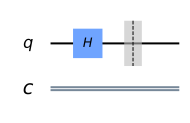

In [11]:
message[0].draw()

別の例として、 `alice_bits` の4番目のビットは `1` であり、 $Z$基底でエンコードされていることがわかります。アリスは対応する量子ビットを  $|1\rangle$ の状態で準備しているわけです：

bit = 1
basis = 0


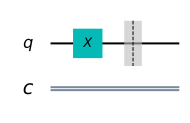

In [12]:
print('bit = %i' % alice_bits[4])
print('basis = %i' % alice_bases[4])
message[4].draw()

この量子ビット列のメッセージはこの後、イブの量子的通信路を使ってボブに送られます：

| Alice's Knowledge |Over Eve's Channel| Bob's Knowledge |
|:-----------------:|:----------------:|:---------------:|
|     alice_bits    |                  |                 |
|    alice_bases    |                  |                 |
|      message      |     message      |     message     |

### 3.3 ステップ3:

さてボブは、各量子ビットをランダムに $X$ または $Z$基底で測定してその情報を保持します：

In [13]:
np.random.seed(seed=0)
n = 100

## Step 1
# Alice generates bits
alice_bits = randint(2, size=n)

## Step 2
# Create an array to tell us which qubits
# are encoded in which bases
alice_bases = randint(2, size=n)
message = encode_message(alice_bits, alice_bases)

## Step 3
# Decide which basis to measure in:
bob_bases = randint(2, size=n)
print(bob_bases)

[1 0 1 0 0 1 1 0 0 0 1 1 0 0 0 0 0 1 0 1 0 0 0 1 1 1 0 0 1 1 1 1 0 0 0 1 1
 0 1 0 0 1 0 1 1 1 1 0 0 0 1 1 1 0 1 1 1 1 0 0 1 1 0 0 0 1 1 0 1 1 1 1 1 0
 0 0 1 0 1 0 1 1 0 0 0 1 0 0 1 1 1 1 0 1 0 0 0 0 1 1]


 `bob_bases` には、ボブが各量子ビットを測定するのに選んだ基底が保持されます。

| Alice's Knowledge |Over Eve's Channel| Bob's Knowledge |
|:-----------------:|:----------------:|:---------------:|
|     alice_bits    |                  |                 |
|    alice_bases    |                  |                 |
|      message      |     message      |     message     |

下記の関数 `measure_message` が対応する測定に使われ、各量子ビットを測定した結果をシミュレートします。測定した結果は `bob_results` に保持します。

In [14]:
def measure_message(message, bases):
    backend = Aer.get_backend('qasm_simulator')
    measurements = []
    for q in range(n):
        if bases[q] == 0: # measuring in Z-basis
            message[q].measure(0,0)
        if bases[q] == 1: # measuring in X-basis
            message[q].h(0)
            message[q].measure(0,0)
        result = execute(message[q], backend, shots=1, memory=True).result()
        measured_bit = int(result.get_memory()[0])
        measurements.append(measured_bit)
    return measurements

In [15]:
np.random.seed(seed=0)
n = 100

## Step 1
# Alice generates bits
alice_bits = randint(2, size=n)

## Step 2
# Create an array to tell us which qubits
# are encoded in which bases
alice_bases = randint(2, size=n)
message = encode_message(alice_bits, alice_bases)

## Step 3
# Decide which basis to measure in:
bob_bases = randint(2, size=n)
bob_results = measure_message(message, bob_bases)

 `message[0]` （ゼロ番目の量子ビットを表している）の回路が、ボブによって $X$測定を施されたことがわかります：

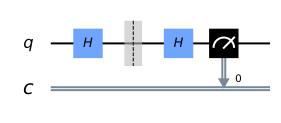

In [16]:
message[0].draw()

ボブはアリスがエンコードしたときと同じ基底をたまたま選んで測定したので、ボブは `0` という結果を得ることが保証されています。下に示すように6番目の量子ビットでは、ボブがランダムに選んだ測定はアリスが選んだものとは同じでないため、ボブの結果がアリスのものと一致する可能性は50%しかありません。

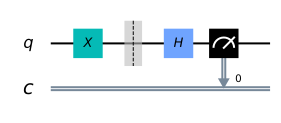

In [17]:
message[6].draw()

In [18]:
print(bob_results)

[0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0]


ボブは自分の結果を秘密にしておきます。

| Alice's Knowledge | Over Eve's Channel | Bob's Knowledge |
|:-----------------:|:------------------:|:---------------:|
|     alice_bits    |                    |                 |
|    alice_bases    |                    |                 |
|      message      |       message      |     message     |
|                   |                    |    bob_bases    |
|                   |                    |   bob_results   |

### 3.4 ステップ4:

この後、アリスはどの量子ビットがどの基底でエンコードされたかを（イブの通信路を使って）公開します：

| Alice's Knowledge | Over Eve's Channel | Bob's Knowledge |
|:-----------------:|:------------------:|:---------------:|
|     alice_bits    |                    |                 |
|    alice_bases    |                    |                 |
|      message      |       message      |     message     |
|                   |                    |    bob_bases    |
|                   |                    |   bob_results   |
|                   |     alice_bases    |   alice_bases   |

そしてボブはそれぞれの量子ビットをどの基底で測定したかを公開します：

| Alice's Knowledge | Over Eve's Channel | Bob's Knowledge |
|:-----------------:|:------------------:|:---------------:|
|     alice_bits    |                    |                 |
|    alice_bases    |                    |                 |
|      message      |       message      |     message     |
|                   |                    |    bob_bases    |
|                   |                    |   bob_results   |
|                   |     alice_bases    |   alice_bases   |
|     bob_bases     |      bob_bases     |      &nbsp;     |

ボブがたまたまあるビットを、アリスが用意したときと同じ基底で測定していれば、 `bob_results` 中のその箇所は `alice_bits` 中の対応する箇所と一致し、このビットを彼らの鍵の一部として使うことができます。2人が別々の基底で測定していれば、ボブの結果はランダムになるので、両者ともその箇所は捨てます。`remove_garbage` はこれを行うための関数です：

In [19]:
def remove_garbage(a_bases, b_bases, bits):
    good_bits = []
    for q in range(n):
        if a_bases[q] == b_bases[q]:
            # If both used the same basis, add
            # this to the list of 'good' bits
            good_bits.append(bits[q])
    return good_bits

アリスとボブは使えないビットを捨て、残ったビットを使って彼らの秘密鍵を作ります：

In [20]:
np.random.seed(seed=0)
n = 100

## Step 1
# Alice generates bits
alice_bits = randint(2, size=n)

## Step 2
# Create an array to tell us which qubits
# are encoded in which bases
alice_bases = randint(2, size=n)
message = encode_message(alice_bits, alice_bases)

## Step 3
# Decide which basis to measure in:
bob_bases = randint(2, size=n)
bob_results = measure_message(message, bob_bases)

## Step 4
alice_key = remove_garbage(alice_bases, bob_bases, alice_bits)
print(alice_key)

[0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0]


| Alice's Knowledge | Over Eve's Channel | Bob's Knowledge |
|:-----------------:|:------------------:|:---------------:|
|     alice_bits    |                    |                 |
|    alice_bases    |                    |                 |
|      message      |       message      |     message     |
|                   |                    |    bob_bases    |
|                   |                    |   bob_results   |
|                   |     alice_bases    |   alice_bases   |
|     bob_bases     |      bob_bases     |                 |
|     alice_key     |                    |     &nbsp;      |

In [21]:
np.random.seed(seed=0)
n = 100

## Step 1
# Alice generates bits
alice_bits = randint(2, size=n)

## Step 2
# Create an array to tell us which qubits
# are encoded in which bases
alice_bases = randint(2, size=n)
message = encode_message(alice_bits, alice_bases)

## Step 3
# Decide which basis to measure in:
bob_bases = randint(2, size=n)
bob_results = measure_message(message, bob_bases)

## Step 4
alice_key = remove_garbage(alice_bases, bob_bases, alice_bits)
bob_key = remove_garbage(alice_bases, bob_bases, bob_results)
print(bob_key)

[0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0]


| Alice's Knowledge | Over Eve's Channel | Bob's Knowledge |
|:-----------------:|:------------------:|:---------------:|
|     alice_bits    |                    |                 |
|    alice_bases    |                    |                 |
|      message      |       message      |     message     |
|                   |                    |    bob_bases    |
|                   |                    |   bob_results   |
|                   |     alice_bases    |   alice_bases   |
|     bob_bases     |      bob_bases     |                 |
|     alice_key     |                    |     bob_key     |

### 3.5 Step 5:

最後に、ボブとアリスは自分たちの鍵からいくつかのビットをランダムに選んで比較し、このプロトコルが正常に機能していることを確認します：

In [22]:
def sample_bits(bits, selection):
    sample = []
    for i in selection:
        # use np.mod to make sure the
        # bit we sample is always in 
        # the list range
        i = np.mod(i, len(bits))
        # pop(i) removes the element of the
        # list at index 'i'
        sample.append(bits.pop(i))
    return sample

アリスとボブは比較した部分を公開します。公開した部分はもはや秘密でなくなってしまうので、鍵から除去します：

In [23]:
np.random.seed(seed=0)
n = 100

## Step 1
# Alice generates bits
alice_bits = randint(2, size=n)

## Step 2
# Create an array to tell us which qubits
# are encoded in which bases
alice_bases = randint(2, size=n)
message = encode_message(alice_bits, alice_bases)

## Step 3
# Decide which basis to measure in:
bob_bases = randint(2, size=n)
bob_results = measure_message(message, bob_bases)

## Step 4
alice_key = remove_garbage(alice_bases, bob_bases, alice_bits)
bob_key = remove_garbage(alice_bases, bob_bases, bob_results)

## Step 5
sample_size = 15
bit_selection = randint(n, size=sample_size)

bob_sample = sample_bits(bob_key, bit_selection)
print("  bob_sample = " + str(bob_sample))
alice_sample = sample_bits(alice_key, bit_selection)
print("alice_sample = "+ str(alice_sample))

  bob_sample = [0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
alice_sample = [0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]


| Alice's Knowledge | Over Eve's Channel | Bob's Knowledge |
|:-----------------:|:------------------:|:---------------:|
|     alice_bits    |                    |                 |
|    alice_bases    |                    |                 |
|      message      |       message      |     message     |
|                   |                    |    bob_bases    |
|                   |                    |   bob_results   |
|                   |     alice_bases    |   alice_bases   |
|     bob_bases     |      bob_bases     |                 |
|     alice_key     |                    |     bob_key     |
|     bob_sample    |     bob_sample     |    bob_sample   |
|    alice_sample   |    alice_sample    |   alice_sample  |

プロトコルが妨害されずに正しく機能していれば、両者のサンプルは一致するはずです：

In [24]:
bob_sample == alice_sample

True

サンプルが一致すれば、（高い確率で） `alice_key == bob_key` であるということになります。こうして、2人はメッセージの暗号化に使うことができる秘密鍵を共有しました！

| Alice's Knowledge | Over Eve's Channel | Bob's Knowledge |
|:-----------------:|:------------------:|:---------------:|
|     alice_bits    |                    |                 |
|    alice_bases    |                    |                 |
|      message      |       message      |     message     |
|                   |                    |    bob_bases    |
|                   |                    |   bob_results   |
|                   |     alice_bases    |   alice_bases   |
|     bob_bases     |      bob_bases     |                 |
|     alice_key     |                    |     bob_key     |
|     bob_sample    |     bob_sample     |    bob_sample   |
|    alice_sample   |    alice_sample    |   alice_sample  |
|     shared_key    |                    |    shared_key   |

In [25]:
print(bob_key)
print(alice_key)
print("key length = %i" % len(alice_key))

[1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0]
[1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0]
key length = 33


## 4. Qiskitの例：盗聴 *あり* 

さてこんどは、アリスとボブの量子メッセージをイブが盗聴しようとしていたかどうかを、2人が知ることができるかどうかを見てみましょう。妨害がない場合と同じ手順を繰り返しますが、ボブが量子ビットを受信する前に、イブが情報を取り出そうと試みます。再現可能な特定の「ランダムな」結果を得られるように、先ほどとは別の乱数種を使いましょう：

In [26]:
np.random.seed(seed=3)

### 4.1 ステップ1:

アリスはランダムなビット列を生成します：

In [27]:
np.random.seed(seed=3)
## Step 1
alice_bits = randint(2, size=n)
print(alice_bits)

[0 0 1 1 0 0 0 1 1 1 0 1 1 1 0 1 1 0 0 0 0 1 1 0 0 0 1 0 0 0 0 1 0 1 1 0 1
 0 0 1 1 0 0 1 0 1 0 1 1 1 1 0 1 0 0 1 1 1 0 0 0 1 0 0 0 1 0 0 1 1 0 0 1 1
 1 0 1 1 1 1 1 1 0 1 0 0 1 1 0 1 0 0 0 0 0 1 1 0 1 1]


### 4.2 ステップ2:

アリスはランダムに選んだ $Z$ および $X$基底を使ってこれらをエンコードし、イブの量子的通信路を使ってボブに送信します：

In [28]:
np.random.seed(seed=3)
## Step 1
alice_bits = randint(2, size=n)
## Step 2
alice_bases = randint(2, size=n)
message = encode_message(alice_bits, alice_bases)
print(alice_bases)

[1 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 1 1 0 0 1 1 0 0 1 1 1 1 0 0
 1 1 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 1 0 0 1 0 0 1 1 1 1
 1 0 0 0 0 0 1 1 1 0 0 0 0 0 0 1 0 1 0 0 0 1 0 1 1 1]


この例の場合、アリスのメッセージの最初の量子ビットは $|+\rangle$ 状態です：

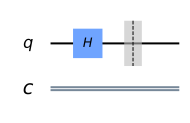

In [29]:
message[0].draw()

### 盗聴！

おっと、いけません！　イブは、通信路を流れている途中でメッセージを盗聴します。ボブがのちにするのと同じやり方で、ランダムに選んだ基底による量子ビットの測定を試みます。

In [30]:
np.random.seed(seed=3)
## Step 1
alice_bits = randint(2, size=n)
## Step 2
alice_bases = randint(2, size=n)
message = encode_message(alice_bits, alice_bases)
## Interception!!
eve_bases = randint(2, size=n)
intercepted_message = measure_message(message, eve_bases)
print(intercepted_message)

[0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1]


ゼロ番目の量子ビットの場合を以下に示します。イブがランダムに選んだ基底はアリスが選んだものと同じではないため、量子ビットは $|+\rangle$ の状態から、$Z$基底では50%の確率で $|0\rangle$ または $|1\rangle$ の状態に変化します：

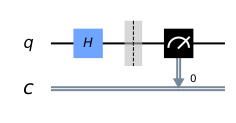

In [31]:
message[0].draw()

### 4.3 ステップ3:

そうしてイブはこの量子ビット列をボブに送り、ボブはそれをランダムに測定します。この例では、アリスが量子ビットを準備したときと同じ基底をボブが（たまたま）選んで測定しました。盗聴がなければ、ボブは `0` を測定することが保証されていたのですが、イブがメッセージの読み取りを試みたために、ボブが `0` でなく `1` を測定する可能性が50%になっています。

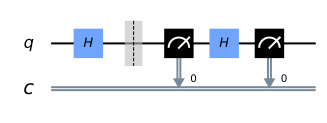

In [32]:
np.random.seed(seed=3)
## Step 1
alice_bits = randint(2, size=n)
## Step 2
alice_bases = randint(2, size=n)
message = encode_message(alice_bits, alice_bases)
## Interception!!
eve_bases = randint(2, size=n)
intercepted_message = measure_message(message, eve_bases)
## Step 3
bob_bases = randint(2, size=n)
bob_results = measure_message(message, bob_bases)
message[0].draw()

### 4.4 ステップ4:

ボブとアリスは自分たちが選んだ基底を公表し、使えないビットを捨てます：

In [33]:
np.random.seed(seed=3)
## Step 1
alice_bits = randint(2, size=n)
## Step 2
alice_bases = randint(2, size=n)
message = encode_message(alice_bits, alice_bases)
## Interception!!
eve_bases = randint(2, size=n)
intercepted_message = measure_message(message, eve_bases)
## Step 3
bob_bases = randint(2, size=n)
bob_results = measure_message(message, bob_bases)
## Step 4
bob_key = remove_garbage(alice_bases, bob_bases, bob_results)
alice_key = remove_garbage(alice_bases, bob_bases, alice_bits)

### 4.5 Step 5:

ボブとアリスは彼らの鍵の同じ位置をランダムに選んで、量子ビットが盗聴されたかどうかを調べます：

In [34]:
np.random.seed(seed=3)
## Step 1
alice_bits = randint(2, size=n)
## Step 2
alice_bases = randint(2, size=n)
message = encode_message(alice_bits, alice_bases)
## Interception!!
eve_bases = randint(2, size=n)
intercepted_message = measure_message(message, eve_bases)
## Step 3
bob_bases = randint(2, size=n)
bob_results = measure_message(message, bob_bases)
## Step 4
bob_key = remove_garbage(alice_bases, bob_bases, bob_results)
alice_key = remove_garbage(alice_bases, bob_bases, alice_bits)
## Step 5
sample_size = 15
bit_selection = randint(n, size=sample_size)
bob_sample = sample_bits(bob_key, bit_selection)
print("  bob_sample = " + str(bob_sample))
alice_sample = sample_bits(alice_key, bit_selection)
print("alice_sample = "+ str(alice_sample))

  bob_sample = [1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1]
alice_sample = [1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]


In [35]:
bob_sample == alice_sample

False

ダメです。ボブの鍵とアリスの鍵は一致しません。イブがステップ2とステップ3の間でメッセージを読もうと試み、量子ビットの状態を変えたためである、ということが私たちにはわかっています。アリスとボブが知りうる範囲においては、これは通信路のノイズによるものであるかもしれません。しかしいずれにしろ、2人は結果をすべて捨て去り、やり直さなければなりません―イブの盗聴の試みは失敗したのです。

## 5. リスク分析

イブがすべての量子ビットを測定するこのタイプの盗聴においては、ボブとアリスのサンプルが一致し、そのためにアリスが脆弱なメッセージをイブの通信路で送ってしまう可能性がわずかにあります。この確率を計算し、量子鍵配送がどの程度危険であるかを見てみましょう。

- アリスとボブが量子ビットの結果を使うためには、2人が同じ基底を選んでいる必要があります。イブもこの基底を選んだ場合には、誤りを引き起こすことなく盗聴に成功します。これが起こる可能性は50%です。
- イブが *間違った* 基底、つまりアリスやボブとは異なった基底を選んだ場合、ボブには依然として、アリスが送ろうとした値を測定する可能性が50%あります。この場合には、盗聴もまた検出されません。
- しかしイブが *間違った* 基底、つまりアリスやボブとは異なった基底を選んだ場合、50%の確率で、アリスが送ろうとした値をボブは測定で得られないことになります。これにより、2人の鍵には違いが *生じます* 。

![risk probability tree](images/qkd_risk.svg)

アリスとボブが鍵のうちの1ビットを比較すると、ビットが一致する確率は $0.75$ であり、一致すればイブの盗聴には気が付かないでしょう。2ビットを比較すれば、盗聴が気づかれない可能性は $0.75^2 = 0.5625$ となります。アリスとボブが比較するのに選んだビット数 ($x$) によって、イブが気づかれない可能性を次のように計算できることがわかります：

$$ P(\text{undetected}) = 0.75^x $$

上で行ったような方法で15ビットを比較することにすれば、イブが気づかれない可能性は1.3%です。これでは危険すぎるというのであれば、15ビットでなく50ビットにしてもよいでしょう。そうすれば知られずに覗き見られてしまう可能性は0.00006%になります。

下に示したセルを実行することで、プロトコルをもう一度試してみることができます。 `sample_size` を小さな値に変えて、アリスとボブの鍵をイブが盗聴するのがどのくらい容易になるかを見てみてください。

In [36]:
n = 100
# Step 1
alice_bits = randint(2, size=n)
alice_bases = randint(2, size=n)
# Step 2
message = encode_message(alice_bits, alice_bases)
# Interception!
eve_bases = randint(2, size=n)
intercepted_message = measure_message(message, eve_bases)
# Step 3
bob_bases = randint(2, size=n)
bob_results = measure_message(message, bob_bases)
# Step 4
bob_key = remove_garbage(alice_bases, bob_bases, bob_results)
alice_key = remove_garbage(alice_bases, bob_bases, alice_bits)
# Step 5
sample_size = 15 # Change this to something lower and see if 
                 # Eve can intercept the message without Alice
                 # and Bob finding out
bit_selection = randint(n, size=sample_size)
bob_sample = sample_bits(bob_key, bit_selection)
alice_sample = sample_bits(alice_key, bit_selection)

if bob_sample != alice_sample:
    print("Eve's interference was detected.")
else:
    print("Eve went undetected!")

Eve's interference was detected.


In [37]:
import qiskit
qiskit.__qiskit_version__

{'qiskit-terra': '0.14.2',
 'qiskit-aer': '0.5.2',
 'qiskit-ignis': '0.3.3',
 'qiskit-ibmq-provider': '0.7.2',
 'qiskit-aqua': '0.7.3',
 'qiskit': '0.19.6'}